In [2]:
import itertools
import numpy as np
import random
import pickle
import matplotlib.pyplot as plt
from math import *
import scipy
from tqdm import tqdm

from utils import *


import matplotlib as mpl

# Set the default font and size
mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['font.size'] = 14

#### Here stability all calculated at equal species abundances

In [3]:
# task: given N=R, given g, pref or x, depletion order and t profile, check dynamical stability of this state
# we can later check this on the data of 4,4 smart species
# we do this analysis for all B abundance are the same
env = {"N":4, "R":4, "logD":log(100)}

def b_to_b(g, dep_order, G, t, F, env, i, j):
    effect = int(i==j)
    R = env["R"]
    # how B changes T
    term1 = np.zeros(R)
    for k in range(1, R+1):
        ind = dep_order.index(k)
        B_list = np.exp(G[:, :ind+1]@t[:ind+1]) # every bug's growth by Rk depletion
        g_list = G[:, ind] # every bug's growth rate by Rk depletion
        term1[k-1] = 1 / ( B_list[G[:, ind]==g[:, k-1]] @ g_list[G[:, ind]==g[:, k-1]] ) # only consider those bugs eating Rk
    term1 = term1 * (-F[:, i])
    # how T changes another B
    term2 = np.zeros(R)
    for k in range(1, R):
        term2[dep_order[k-1]-1] = G[j, k-1] - G[j, k]
    term2[dep_order[-1]-1] = G[j, R-1]
    effect += term1@term2
    # print(i, j, term1, term2)
    return effect

def Pert_mat(g, dep_order, G, t, F, env):
    N = env["N"]
    P = np.zeros([N, N])
    for i in range(N):
        for j in range(N):
            P[i, j] = b_to_b(g, dep_order, G, t, F, env, i, j)
    return P


import matplotlib as mpl
# Set the default font and size
mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['font.size'] = 14

In [3]:
g = np.array([[1.2627103 , 1.06705159, 0.96384722, 1.22292326],
       [0.85227897, 0.8964752 , 0.90444464, 1.07806775],
       [1.15898257, 0.91419782, 0.9286182 , 0.90208499],
       [1.08283869, 0.93373807, 1.02084101, 1.08038352]])

pref_list = np.array([[3, 2, 4, 1],
       [4, 3, 2, 1],
       [3, 1, 4, 2],
       [3, 4, 2, 1]])

N, R, logD = env["N"], env["R"], env["logD"]

In [4]:
# check one example for the diauxers -- only the 5th depletion order should be stable, from the ode simulations.
for order in allowed_orders(pref_list):
    G = G_mat(g, pref_list, order, N, R)
    if(np.linalg.matrix_rank(G)>=N):
        t = np.linalg.inv(G)@np.ones(R)*logD
        if(np.sum(t<=0)==0):
            F = F_mat(g, pref_list, order, logD, N, R)
            print(np.max(np.real(np.linalg.eigvals(Pert_mat(g, order, G, t, F, env)))))
    

1.124644721143852
1.0032450350912747
1.0852798328004716
1.0059532077400937
0.9914685010569423
1.0096378832012776


In [30]:
# systematically check it
check = np.zeros([2, 2])
filename = "1_season_smart_species2_stability.pkl"
data = pickle.load(open(filename, "rb"))
R, logD, communities = data["R"], data["logD"], data["communities"]
N = R
for item in communities:
    g, pref_list = item["g"], item["pref_list"]
    if(item["possible_dep_order"]!=[]):
        for idx, dep_order in enumerate(item["possible_dep_order"]):
            g, pref_list = item["g"], item["pref_list"]
            F = F_mat(g, pref_list, dep_order, logD, N, R)
            G = G_mat(g, pref_list, dep_order, N, R)
            t = np.linalg.inv(G)@np.ones(R)*logD
            env = {"N":N, "R":R, "logD":logD}
            ode = int(item['possible_dep_order_survivenum'][idx]==4)
            mat = int(np.abs(np.max(np.real(np.linalg.eigvals(Pert_mat(g, dep_order, G, t, F, env)))))<1+1e-9)
            check[ode][mat]+=1

print(check)

[[   7.    0.]
 [ 151. 2261.]]


In [39]:
item = data["communities"][5530]
g, pref_list = item["g"], item["pref_list"]
if(item["possible_dep_order"]!=[]):
    for idx, dep_order in enumerate(item["possible_dep_order"]):
        g, pref_list = item["g"], item["pref_list"]
        F = F_mat(g, pref_list, dep_order, logD, N, R)
        G = G_mat(g, pref_list, dep_order, N, R)
        t = np.linalg.inv(G)@np.ones(R)*logD
        env = {"N":N, "R":R, "logD":logD}
        print(np.linalg.eigvals(Pert_mat(g, dep_order, G, t, F, env)))

[0.19086189 1.01470336 0.76522144 0.89324439]


In [52]:
filename = "1_season_co-ut_uniform_species_stability.pkl"
data = pickle.load(open(filename, "rb"))
R, logD, communities = data["R"], data["logD"], data["communities"]
N = R
for item in communities:
    if(item["possible_dep_order_stability"].count(0)>0):
        print("!!!")

In [5]:
# now let's check the stability of all those diauxers!
data = pickle.load(open("1_season_smart_species.pkl", "rb"))
N, R, logD = data["R"], data["R"], data["logD"]
env = {"N":N, "R":R, "logD":logD}
all = []
stable = []
B0 = np.ones(N)
 
for item in tqdm(data["communities"]):
    if(len(item["possible_dep_order"])==1):
        # then check stability
        g, pref_list, dep_order = item["g"], item["pref_list"], item["possible_dep_order"][0]
        G = G_mat(g, pref_list, dep_order, N, R)
        t = np.linalg.inv(G)@np.ones(R)*logD
        F = F_mat(g, pref_list, dep_order, logD, N, R)
        stable.append(np.abs(np.max(np.real(np.linalg.eigvals(Pert_mat(g, dep_order, G, t, F, B0, env))))) < 1)
        all.append(1)

100%|██████████| 20000/20000 [00:01<00:00, 10341.36it/s]


In [6]:
print(sum(stable), sum(all))

2215 2331


In [4]:
# now let's look at these heatmaps
data = pickle.load(open("smartbugs_heatmap.pkl", "rb"))
real_parts = []
imag_parts = []
checked_data = []
for case in data:
    N, R = case["N"], case["R"]
    logD = log(100)
    env = {"N":N, "R":R, "logD":log(100)}
    if(N==R):
        real_parts.append([])
        imag_parts.append([])
        B0 = np.ones(N)
        communities_new = case["communities"]
        stable = []
        for item in tqdm(communities_new):
            for order in item["possible_orders"]:
                g, pref_list, dep_order = item["g"], item["pref_list"], order
                G = G_mat(g, pref_list, dep_order, N, R)
                t = np.linalg.inv(G)@np.ones(R)*logD
                F = F_mat(g, pref_list, dep_order, logD, N, R)
                for value in np.linalg.eigvals(Pert_mat(g, dep_order, G, t, F, env)):
                    value = complex(value)
                    real_parts[-1].append(value.real)
                    imag_parts[-1].append(value.imag)
                if  np.abs(np.max(np.real(np.linalg.eigvals(Pert_mat(g, dep_order, G, t, F, env))))) < 1:
                    stable.append(1)
                    break
        checked_data.append(sum(stable))

original_data = []
for case in data:
    N, R = case["N"], case["R"]
    if(N==R):
        original_data.append(case["N_assemble"])

100%|██████████| 5000/5000 [00:00<00:00, 6666.63it/s]


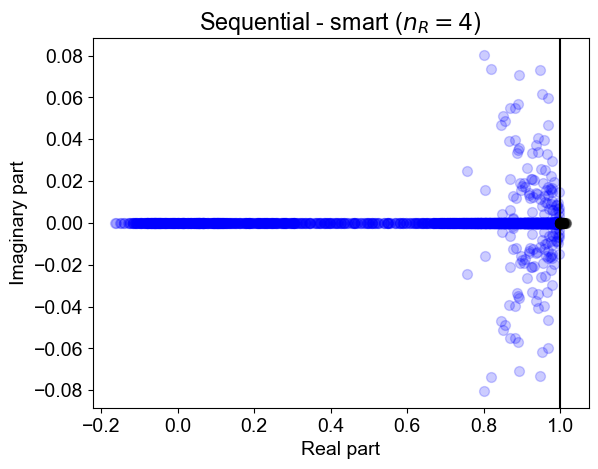

In [77]:
# plt.scatter(real_parts[-1], imag_parts[-1], color = 'g', alpha= 0.2)
plt.axvline(1, color='k')
plt.scatter([i for i in real_parts[2] if abs(i)<=1], [imag_parts[2][idx] for idx, i in enumerate(real_parts[2]) if abs(i)<=1], color = 'b', s=50, alpha= 0.2)
plt.scatter([i for i in real_parts[2] if abs(i)>1], [imag_parts[2][idx] for idx, i in enumerate(real_parts[2]) if abs(i)>1], color = 'k', s=50, alpha=0.4)
plt.xlabel("Real part")
plt.ylabel("Imaginary part")
plt.title("Sequential - smart ($n_R=4$)")
plt.savefig("figures/supp_spectra_smart.pdf")

In [78]:
# now let's look at these heatmaps
data = pickle.load(open("randombugs_heatmap.pkl", "rb"))
real_parts = []
imag_parts = []
checked_data_random = []
for case in data:
    N, R = case["N"], case["R"]
    logD = log(100)
    env = {"N":N, "R":R, "logD":log(100)}
    if(N==R):
        real_parts.append([])
        imag_parts.append([])
        B0 = np.ones(N)
        communities_new = case["communities"]
        stable = []
        for item in tqdm(communities_new):
            for order in item["possible_orders"]:
                g, pref_list, dep_order = item["g"], item["pref_list"], order
                G = G_mat(g, pref_list, dep_order, N, R)
                t = np.linalg.inv(G)@np.ones(R)*logD
                F = F_mat(g, pref_list, dep_order, logD, N, R)
                for value in np.linalg.eigvals(Pert_mat(g, dep_order, G, t, F, env)):
                    value = complex(value)
                    real_parts[-1].append(value.real)
                    imag_parts[-1].append(value.imag)
                if np.abs(np.max(np.real(np.linalg.eigvals(Pert_mat(g, dep_order, G, t, F, env))))) < 1+1e-9:
                    stable.append(1)
                    break
        checked_data_random.append(sum(stable))

original_data_random = []
for case in data:
    N, R = case["N"], case["R"]
    if(N==R):
        original_data_random.append(case["N_assemble"])

100%|██████████| 5000/5000 [00:01<00:00, 3048.78it/s]


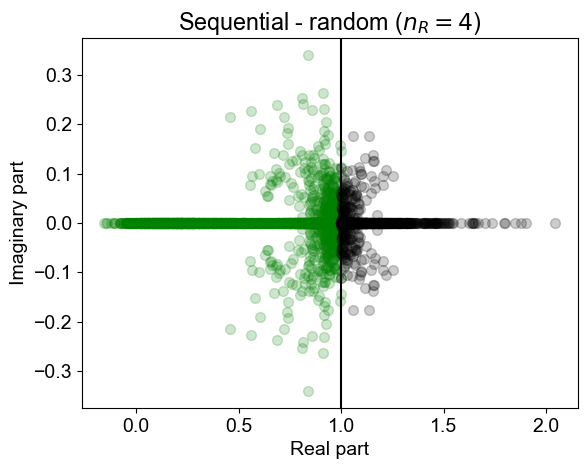

In [79]:
# plt.scatter(real_parts[-1], imag_parts[-1], color = 'g', alpha= 0.2)
plt.axvline(1, color='k')
plt.scatter([i for i in real_parts[2] if abs(i)<=1], [imag_parts[2][idx] for idx, i in enumerate(real_parts[2]) if abs(i)<=1], color = 'g', s=50, alpha= 0.2)
plt.scatter([i for i in real_parts[2] if abs(i)>1], [imag_parts[2][idx] for idx, i in enumerate(real_parts[2]) if abs(i)>1], color = 'k', s=50, alpha=0.2)
plt.xlabel("Real part")
plt.ylabel("Imaginary part")
plt.title("Sequential - random ($n_R=4$)")
plt.savefig("figures/supp_spectra_random.pdf")

In [80]:
data = pickle.load(open("co-ut_uniform_heatmap.pkl", "rb"))
real_parts = []
imag_parts = []
checked_data_cout = []
for case in data:
    N, R = case["N"], case["R"]
    logD = log(100)
    env  = {"N":N, "R":R, "logD":log(100)}
    if(N==R):
        real_parts.append([])
        imag_parts.append([])
        B0 = np.ones(N)
        communities_new = case["communities"]
        stable = []
        for item in tqdm(communities_new):
            for order in item["possible_orders"]:
                g, x, dep_order = item["g"], item["x"], order
                G = G_mat_co(g, x, dep_order, N, R)
                t = np.linalg.inv(G)@np.ones(R)*logD
                F = F_mat_co(g, x, dep_order, logD, N, R)
                for value in np.linalg.eigvals(Pert_mat_co(g, x, list(dep_order), G, t, F, env)):
                    value = complex(value)
                    real_parts[-1].append(value.real)
                    imag_parts[-1].append(value.imag)
                if np.abs(np.max(np.real(np.linalg.eigvals(Pert_mat_co(g, x, list(dep_order), G, t, F, env))))) < 1+1e-9:
                    stable.append(1)
                    break
        checked_data_cout.append(sum(stable))

original_data_cout = []
for case in data:
    N, R = case["N"], case["R"]
    if(N==R):
        original_data_cout.append(case["N_assemble"])

100%|██████████| 5000/5000 [00:02<00:00, 2343.54it/s]


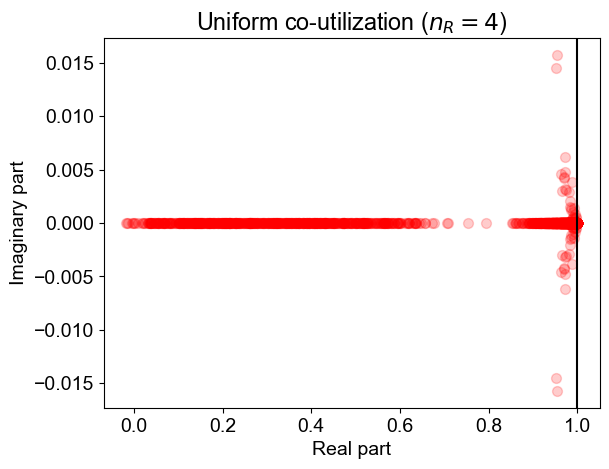

In [81]:
# plt.scatter(real_parts[-1], imag_parts[-1], color = 'g', alpha= 0.2)
plt.axvline(1, color='k')
plt.scatter([i for i in real_parts[2] if abs(i)<=1], [imag_parts[2][idx] for idx, i in enumerate(real_parts[2]) if abs(i)<=1], color = 'r', s=50, alpha= 0.2)
plt.scatter([i for i in real_parts[2] if abs(i)>1], [imag_parts[2][idx] for idx, i in enumerate(real_parts[2]) if abs(i)>1], color = 'k', s=50, alpha=0.2)
plt.xlabel("Real part")
plt.ylabel("Imaginary part")
plt.title("Uniform co-utilization ($n_R=4$)")
plt.savefig("figures/supp_spectra_uniform_cout.pdf")

In [46]:
data = pickle.load(open("co-ut_random_heatmap.pkl", "rb"))
checked_data_cout = []
real_parts = []
imag_parts = []
for case in data:
    N, R = case["N"], case["R"]
    logD = log(100)
    env  = {"N":N, "R":R, "logD":log(100)}
    if(N==R):
        real_parts.append([])
        imag_parts.append([])
        communities_new = case["communities"]
        stable = []
        for item in tqdm(communities_new):
            for order in item["possible_orders"]:
                g, x, dep_order = item["g"], item["x"], order
                G = G_mat_co(g, x, dep_order, N, R)
                t = np.linalg.inv(G)@np.ones(R)*logD
                F = F_mat_co(g, x, dep_order, logD, N, R)
                for value in np.linalg.eigvals(Pert_mat_co(g, x, list(dep_order), G, t, F, env)):
                    value = complex(value)
                    real_parts[-1].append(value.real)
                    imag_parts[-1].append(value.imag)
                if np.abs(np.max(np.real(np.linalg.eigvals(Pert_mat_co(g, x, list(dep_order), G, t, F, env))))) < 1+1e-9:
                    stable.append(1)
                    break
        checked_data_cout.append(sum(stable))

original_data_cout = []
for case in data:
    N, R = case["N"], case["R"]
    if(N==R):
        original_data_cout.append(case["N_assemble"])

100%|██████████| 5000/5000 [00:01<00:00, 2930.84it/s]


Text(0.5, 1.0, 'Random co-utilization ($n_R=4$)')

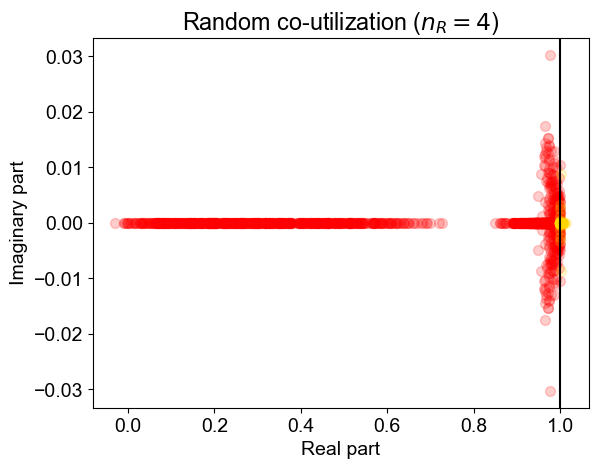

In [48]:
# plt.scatter(real_parts[-1], imag_parts[-1], color = 'g', alpha= 0.2)
plt.axvline(1, color='k')
plt.scatter([i for i in real_parts[2] if abs(i)<=1], [imag_parts[2][idx] for idx, i in enumerate(real_parts[2]) if abs(i)<=1], color = 'r', s=50, alpha= 0.2)
plt.scatter([i for i in real_parts[2] if abs(i)>1], [imag_parts[2][idx] for idx, i in enumerate(real_parts[2]) if abs(i)>1], color = 'gold', s=50, alpha=0.2)
plt.xlabel("Real part")
plt.ylabel("Imaginary part")
plt.title("Random co-utilization ($n_R=4$)")

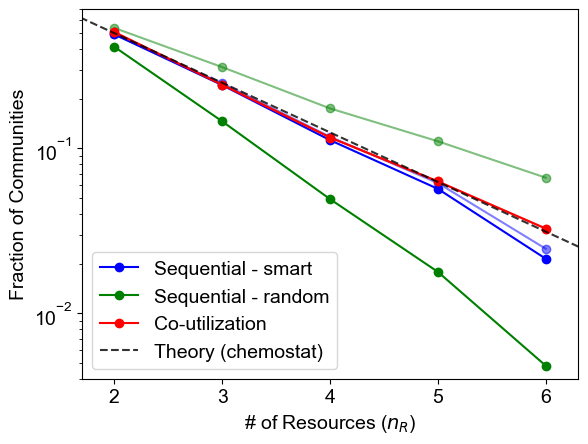

In [83]:
plt.plot(range(2, 7), np.array(original_data)/5000, marker="o", color="b", alpha=0.5)
plt.plot(range(2, 7), np.array(checked_data)/5000, marker="o", color="b", alpha=1, label="Sequential - smart")
plt.plot(range(2, 7), np.array(original_data_random)/5000, marker="o", color="g", alpha=0.5)
plt.plot(range(2, 7), np.array(checked_data_random)/5000, marker="o", color="g", alpha=1, label="Sequential - random")
plt.plot(range(2, 7), np.array(original_data_cout)/5000, marker="o", color="r", alpha=0.5)
plt.plot(range(2, 7), np.array(checked_data_cout)/5000, marker="o", color="r", alpha=1, label="Co-utilization")
plt.yscale("log")
plt.xlabel("# of Resources ($n_R$)")
plt.ylabel("Fraction of Communities")
plt.xlim(1.7, 6.3)
plt.ylim(0.004, 0.7)

xspace = np.linspace(1, 7, 300)
yspace = 1/2**(xspace-1)
plt.plot(xspace, yspace, color='k', linestyle="--", alpha=0.8, label = "Theory (chemostat)")

plt.legend()
plt.savefig("figures/dyn_stability.pdf")
plt.show()